In [2]:
# Requires 0.24
import os
import sys
sys.path.insert(1,os.path.abspath('../0. Not_git/Sources/scikit-learn/0.24.0'))
import sklearn
print(sklearn.__version__)
#this will be 0.24.2 

0.24.0


### Import libraries

In [3]:
# Modules
import numpy as np
import math
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import pandas as pd

# Metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Autoregressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg

# Hyperparameter Grid search
from skforecast.model_selection import grid_search_forecaster

# Backtesting
from skforecast.model_selection import backtesting_forecaster

# Models
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor 
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor

import plotly.io as pio

In [4]:
# To render plotly into GitHub
pio.renderers.default = "svg"

### Load Data

In [39]:
exogenous_features = True

In [40]:
# Input path and filename
path = '../5. Master_thesis/Datasets/Output_files/'

# Load files into a pandas dataframes
if exogenous_features:
    file = path + '2.xlsx'
else:
    file = path + 'Orders.xlsx'
    
df = pd.concat(pd.read_excel(file, sheet_name=None), ignore_index=True)

# Set index
df = df.set_index("Date").asfreq('MS')

# Dependant variable 
dep_var = 'Orders'

In [41]:
df_diff = df.copy()

In [42]:
if exogenous_features:
    columns = ['Orders', 'CCI', 'CPI', 'Unemployment_rate', 'Long_term_interest_rates', 'Avg_Fuel_Price']
    for c in columns:
        df_diff[c] = df_diff[c].diff(1)
else:
    df_diff['Orders_diff'] = df_diff.Orders.diff(1)
    df_diff.drop(['Orders'], axis=1, inplace=True)
    df_diff = df_diff.rename(columns={'Orders_diff': 'Orders'})    

df_diff.dropna(inplace=True)

In [43]:
df_diff

,Orders,CCI,CPI,Unemployment_rate,Long_term_interest_rates,Avg_Fuel_Price,TIV,Orders_rolled_detrended,TIV_rolled_detrended,Orders_lagged_12m
Date,,,,,,,,,,
2007-02-01,-360.0,-0.08610,-0.117595,0.0,0.030000,0.013333,11852,-252.416667,-1368.750000,1079
2007-03-01,11.0,-0.03900,0.389550,-0.1,-0.100000,0.050000,14386,-194.666667,1230.000000,1210
2007-04-01,104.0,0.04540,-0.012681,-0.6,0.220000,0.020000,13761,-57.833333,580.916667,1147
2007-05-01,103.0,0.00410,-0.199371,0.1,0.130000,0.033333,14917,57.250000,1870.166667,1001
2007-06-01,-31.0,0.01430,0.096005,0.3,0.290000,0.003333,13274,48.083333,490.250000,1087
...,...,...,...,...,...,...,...,...,...,...
2022-08-01,136.0,-0.38799,-0.169369,0.1,-0.088953,-0.186667,8163,-0.916667,369.500000,256
2022-09-01,-26.0,-0.47267,0.503214,0.1,0.795932,-0.020000,7867,-24.333333,50.750000,259
2022-10-01,-40.0,-0.14612,0.191470,-0.9,0.473650,0.003333,7132,-65.166667,-648.916667,178


In [44]:
df = df_diff

### Split Data

In [45]:
# Split data
steps = 36  # Number of months of testing
train = df[:-steps]
test  = df[-steps:]

print(f"Dataset length : (n={len(df)})")
print(f"Train dates    : {train.index.min()} --- {train.index.max()}  (n={len(train)})")
print(f"Test dates     : {test.index.min()} --- {test.index.max()}  (n={len(test)})")

start = train.index.min()
end = df.index.max()
start_test = test.index.min()

start, end, start_test

Dataset length : (n=191)
Train dates    : 2007-02-01 00:00:00 --- 2019-12-01 00:00:00  (n=155)
Test dates     : 2020-01-01 00:00:00 --- 2022-12-01 00:00:00  (n=36)


(Timestamp('2007-02-01 00:00:00', freq='MS'),
 Timestamp('2022-12-01 00:00:00', freq='MS'),
 Timestamp('2020-01-01 00:00:00', freq='MS'))

In [46]:
# Define exogenous variables
df_exo = df[df.columns.difference([dep_var])]
train_exo = train[train.columns.difference([dep_var])]
test_exo = test[test.columns.difference([dep_var])]

In [47]:
train_exo.shape, test_exo.shape

((155, 9), (36, 9))

In [48]:
train.shape, test.shape

((155, 10), (36, 10))

### Scoring function

In [49]:
metrics = pd.DataFrame()

def scoring(model_name, y_true, y_pred, print_metrics: bool, plot_results: bool):

    # Calculate metrics
    mae = mean_absolute_error(y_true, y_pred)                      # MAE (Mean Absolute Error)
    mse = mean_squared_error(y_true, y_pred)                       # MSE (Mean Squared Error)
    rmse = math.sqrt(mse)                                          # RMSE (Root Mean Squared Error)
    r2 = r2_score(y_true, y_pred)                                  # R2 (R-squared - Coeficient of determination)                           
    mape = np.mean(np.abs((y_true - y_pred) /y_true)) * 100        # MAPE
    accuracy = 100 - mape                                          # Accuracy

    # Append metrics for summary
    metrics[model_name] = [mae, mse, rmse, r2, mape, accuracy]
    metrics.index = ['Mean Absolute Error', 
                    'Mean Squared Error', 
                    'Root Mean Squared Error',
                    'R^2',
                    'Mean Absolute Percentage Error',
                    'Accuracy']

    # Print metrics  
    if print_metrics:
 
        print(model_name, 'Model Performance:')                             # Model name
        print('Mean Absolute Error: {:0.2f}.'.format(mae))                  # MAE
        print('Mean Squared Error: {:0.2f}.'.format(mse))                   # MSE
        print('Root Mean Squared Error: {:0.2f}.'.format(rmse))             # RMSE  
        print('R^2 Score = {:0.2f}.'.format(r2))                            # R2
        print('Mean Absolute Percentage Error: {:0.2f}%.'.format(mape))     # MAPE 
        print('Accuracy = {:0.2f}%.'.format(accuracy))                      # Accuracy
        
    # Plot Actual values vs predicted values
    if plot_results:
        
        df = pd.DataFrame(y_true)

        fig= make_subplots(rows=2, cols=1)
        
        fig.add_trace(go.Scatter(dict(x=df.index, y=y_true, mode='lines', name= 'Actual'), legendgroup="Preds"), row=1, col=1)
        fig.add_trace(go.Scatter(dict(x=df.index, y=y_pred, mode='lines', name= 'Predicted'), legendgroup="Preds"), row=1, col=1)
        
        fig.add_trace(go.Scatter(dict(x=train.index, y=train[dep_var], mode='lines', name= 'Train'), legendgroup="Full"), row=2, col=1)
        fig.add_trace(go.Scatter(dict(x=test.index, y=test[dep_var], mode='lines', name= 'Test'), legendgroup="Full"), row=2, col=1)
        fig.add_trace(go.Scatter(dict(x=test.index, y=y_pred, mode='lines', name= 'Forecast'), legendgroup="Full"), row=2, col=1)

        fig.update_layout(height=600, width=1000, title_text=model_name + " Predictions")    

        fig.show()         

### Models

Extra Tree Model Performance:
Mean Absolute Error: 58.84.
Mean Squared Error: 5501.51.
Root Mean Squared Error: 74.17.
R^2 Score = 0.52.
Mean Absolute Percentage Error: 189.22%.
Accuracy = -89.22%.


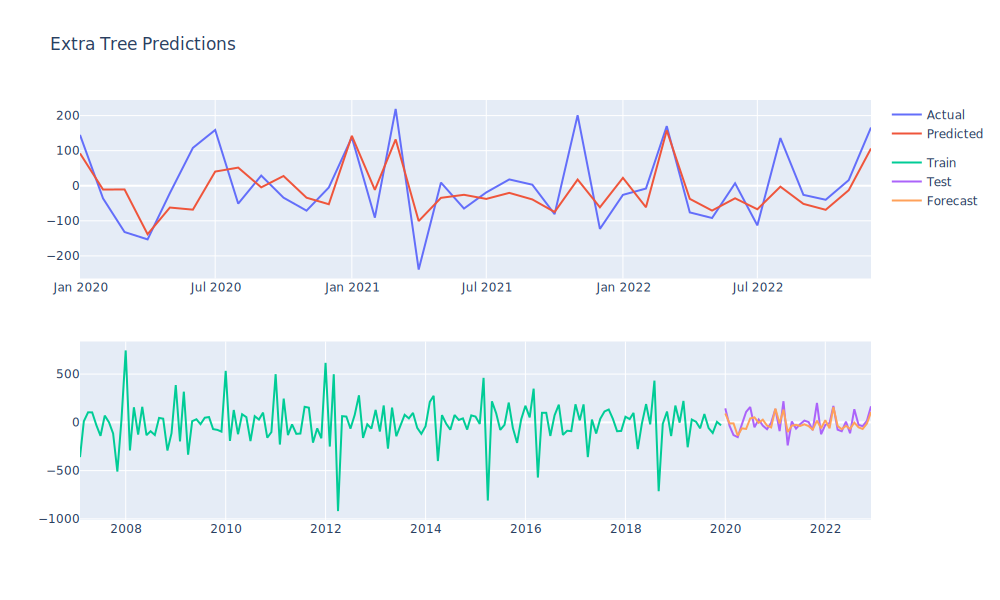

XGBoost Model Performance:
Mean Absolute Error: 60.18.
Mean Squared Error: 6054.82.
Root Mean Squared Error: 77.81.
R^2 Score = 0.47.
Mean Absolute Percentage Error: 141.47%.
Accuracy = -41.47%.


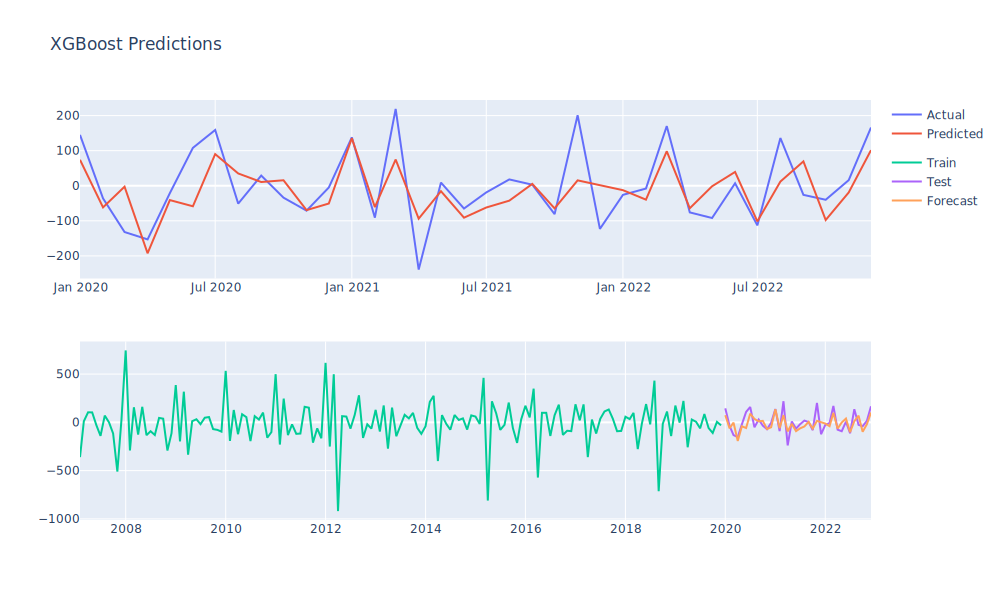

Gradient Boosting Model Performance:
Mean Absolute Error: 62.94.
Mean Squared Error: 6007.66.
Root Mean Squared Error: 77.51.
R^2 Score = 0.48.
Mean Absolute Percentage Error: 196.93%.
Accuracy = -96.93%.


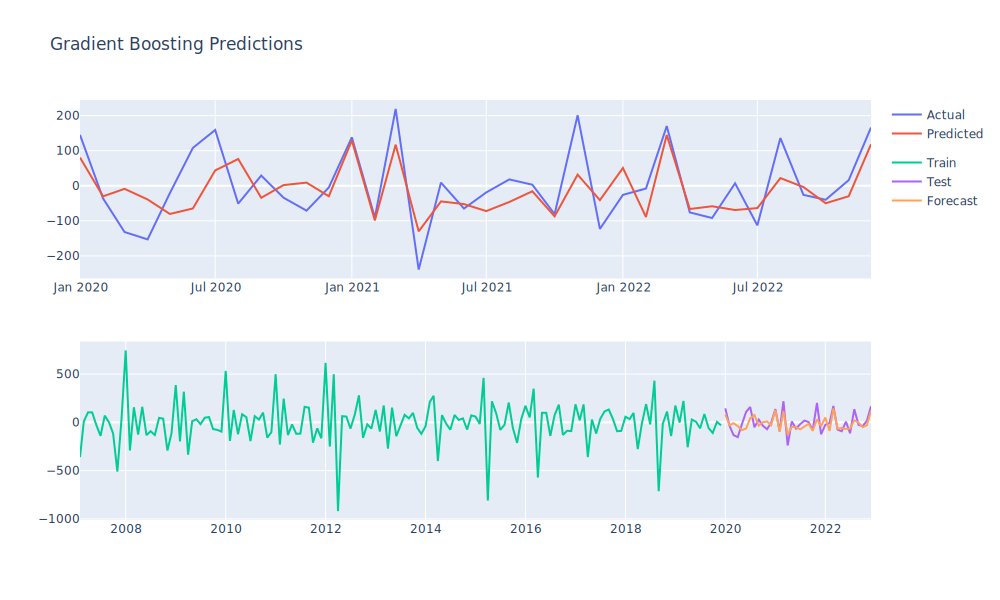

Random Forest Model Performance:
Mean Absolute Error: 61.94.
Mean Squared Error: 5893.53.
Root Mean Squared Error: 76.77.
R^2 Score = 0.49.
Mean Absolute Percentage Error: 232.18%.
Accuracy = -132.18%.


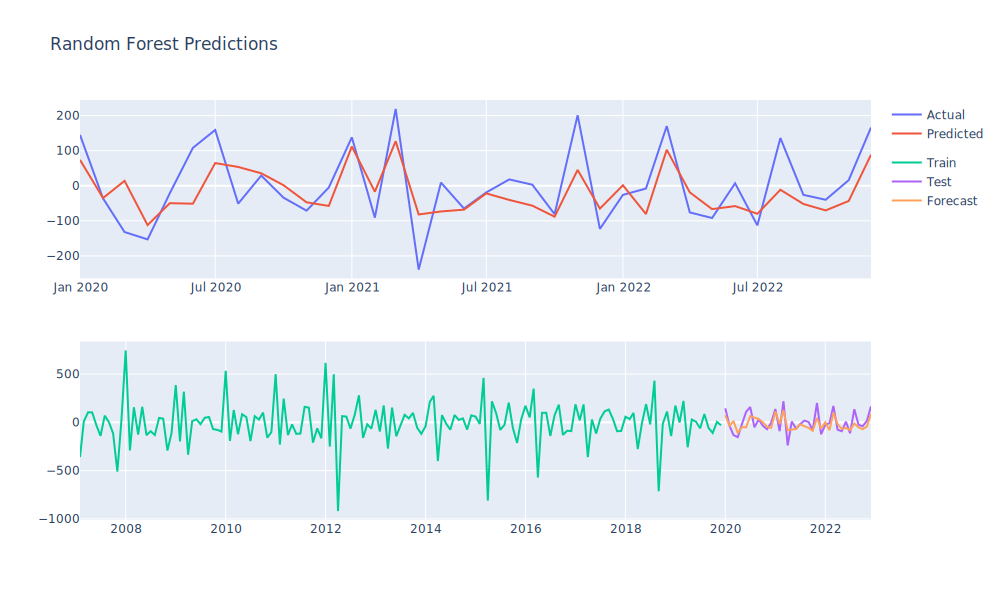

Ada Boost Model Performance:
Mean Absolute Error: 62.99.
Mean Squared Error: 6908.09.
Root Mean Squared Error: 83.11.
R^2 Score = 0.40.
Mean Absolute Percentage Error: 93.40%.
Accuracy = 6.60%.


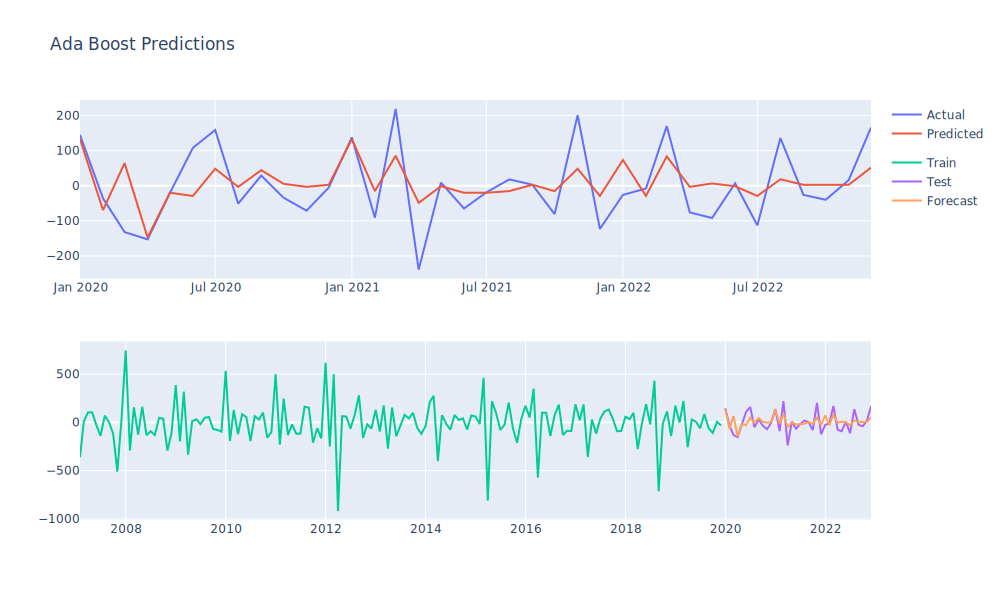

LightGBM Model Performance:
Mean Absolute Error: 77.84.
Mean Squared Error: 9481.49.
Root Mean Squared Error: 97.37.
R^2 Score = 0.18.
Mean Absolute Percentage Error: 261.41%.
Accuracy = -161.41%.


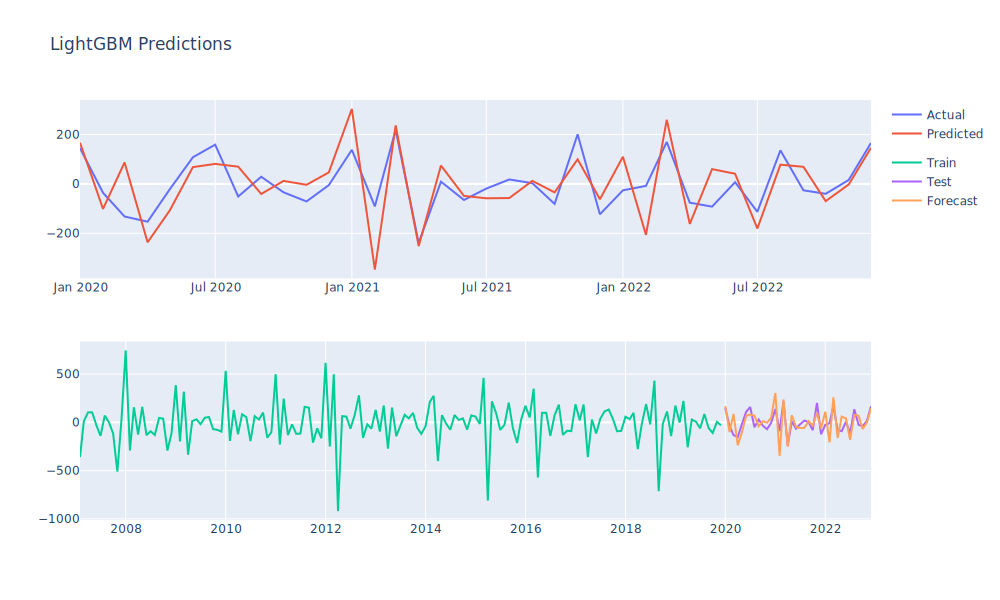

Decision Tree Model Performance:
Mean Absolute Error: 87.31.
Mean Squared Error: 10815.19.
Root Mean Squared Error: 104.00.
R^2 Score = 0.06.
Mean Absolute Percentage Error: 339.78%.
Accuracy = -239.78%.


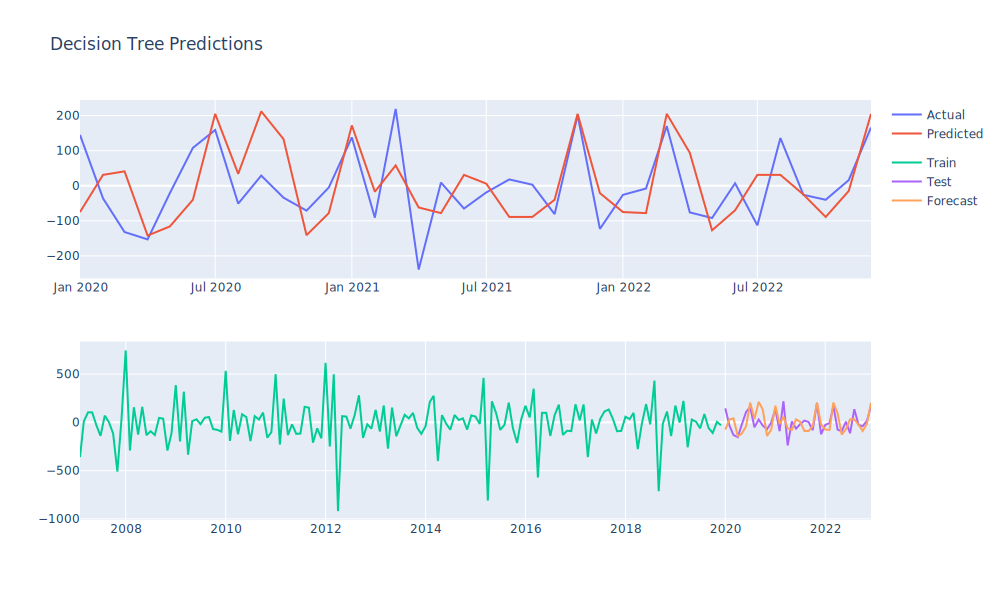

In [50]:
# Hyperparameters
#et_params = [{"C":0.01}, {"C":0.1}, {"C":1}, {"C":10}]
et_params = [{}]
xgb_params = [{}]
gb_params = [{}]
rf_params = [{}]
ab_params = [{}]
lgbm_params = [{}]
dt_params = [{}]

modelclasses = [
    ["Extra Tree", ExtraTreesRegressor, et_params],
    ["XGBoost", XGBRegressor, xgb_params],
    ["Gradient Boosting", GradientBoostingRegressor, gb_params],
    ["Random Forest", RandomForestRegressor, rf_params],
    ["Ada Boost", AdaBoostRegressor, ab_params],
    ["LightGBM", LGBMRegressor, lgbm_params],
    ["Decision Tree", DecisionTreeRegressor, dt_params]
]

number_of_lags = 12

for model_name, Model, params_list in modelclasses:
    for params in params_list:

        # Create forecaster
        forecaster = ForecasterAutoreg(
                regressor = Model(**params),
                lags = number_of_lags
        )
        # Fit model
        forecaster.fit(y=train[dep_var], exog=train_exo)
        
        # Predict
        preds = forecaster.predict(steps=steps, exog=test_exo)

        # Score
        scoring(model_name, test[dep_var], preds, True, True)

### Summary

In [37]:
metrics

,Extra Tree,XGBoost,Gradient Boosting,Random Forest,Ada Boost,LightGBM,Decision Tree
Mean Absolute Error,81.927222,128.820001,83.783836,86.322500,91.238613,119.849301,144.750000
Mean Squared Error,11968.446372,25634.211083,11370.054380,11944.857075,13520.387449,22820.797622,38490.638889
Root Mean Squared Error,109.400395,160.106874,106.630457,109.292530,116.277201,151.065541,196.190313
R^2,-0.038300,-1.223848,0.013612,-0.036254,-0.172936,-0.979776,-2.339184
Mean Absolute Percentage Error,214.446729,331.253074,215.188738,208.873806,179.614126,459.257602,484.206438
Accuracy,-114.446729,-231.253074,-115.188738,-108.873806,-79.614126,-359.257602,-384.206438


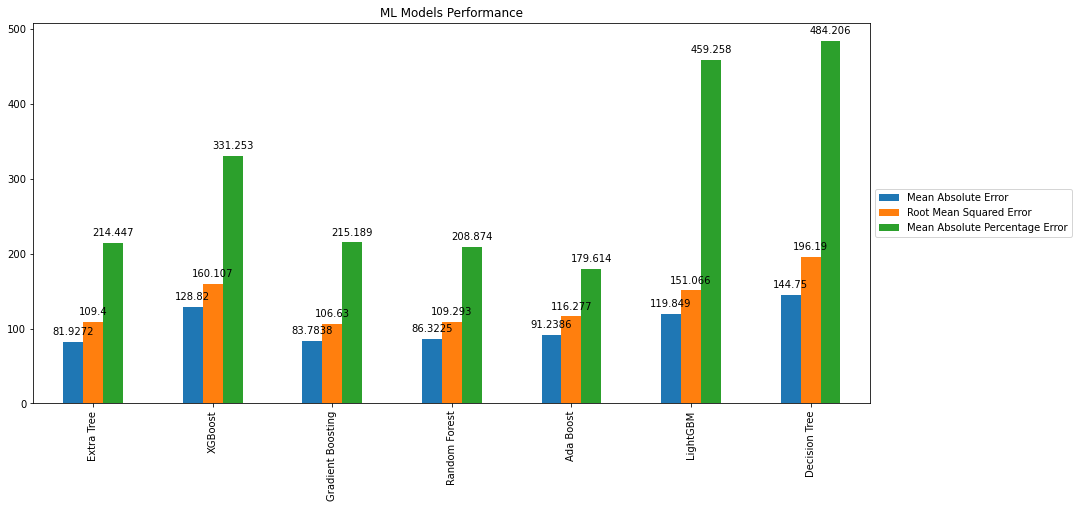

In [38]:
chart = metrics.transpose()
chart.drop(['Mean Squared Error', 'R^2', 'Accuracy'], axis=1, inplace=True)

ax = chart.plot.bar(title="ML Models Performance", figsize=(15,7))
for container in ax.containers:
    ax.bar_label(container, padding=5)
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))